In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


MODEL_SAVE_FOLDER = '/content/drive/My Drive/Colab Notebooks/capstone2-DL'

def getData(path=MODEL_SAVE_FOLDER+'/images/', num_each=1000):
    data = []
    class_num = -1

    for idx, (root, dirs, files) in enumerate(os.walk(path)):
      num = 0
      
      if root == path:
        class_num = len(dirs)
        continue

      label = np.zeros(class_num)
      label[idx - 1] = 1

      for fname in files:
        num += 1
        if num > num_each:
          break
        full_fname = os.path.join(root, fname)
        data.append([full_fname, label])
        # print("success", full_fname)

    return np.array(data)

In [0]:
IMG_SIZE = 224
CHANNELS = 3

In [0]:
def parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [0]:
def create_dataset(filenames, labels, is_training=True, batch_size=256, 
                   autotune=tf.data.experimental.AUTOTUNE, 
                   shuffle_buffer_size=1024):
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=autotune)
    
    if is_training == True:
        dataset = dataset.cache()
        dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=autotune)
    
    return dataset

In [0]:
from tensorflow.keras import layers
import tensorflow_hub as hub


def create_model(n_labels = 13):
  feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
  feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))
  feature_extractor_layer.trainable = False

  model = tf.keras.Sequential([feature_extractor_layer, 
                               layers.Dense(1024, activation='relu', name='hidden_layer_1'),
                               layers.Dense(512, activation='relu', name='hidden_layer_2'),
                               layers.Dense(n_labels, activation='sigmoid', name='output')])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=macro_double_soft_f1,
              metrics=[macro_f1, 'accuracy'])
  return model

In [0]:
def macro_f1(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    
    return macro_f1

In [0]:
def macro_double_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    This version uses the computation of soft-F1 for both positive and negative class for each label.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    tn = tf.reduce_sum((1 - y_hat) * (1 - y), axis=0)
    soft_f1_class1 = 2*tp / (2*tp + fn + fp + 1e-16)
    soft_f1_class0 = 2*tn / (2*tn + fn + fp + 1e-16)
    cost_class1 = 1 - soft_f1_class1 # reduce 1 - soft-f1_class1 in order to increase soft-f1 on class 1
    cost_class0 = 1 - soft_f1_class0 # reduce 1 - soft-f1_class0 in order to increase soft-f1 on class 0
    cost = 0.5 * (cost_class1 + cost_class0) # take into account both class 1 and class 0
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [0]:
from sklearn.model_selection import train_test_split


data = getData(num_each=1000)

X_data = data[:, 0].tolist()
y_data = data[:, 1].tolist()

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.4, random_state=321)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state = 123)

train_ds = create_dataset(X_train, y_train)
test_ds = create_dataset(X_test, y_test)
val_ds = create_dataset(X_val, y_val)

In [0]:
loaded_model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/capstone2-DL/models/layer2_1024_512.h5', 
                                  custom_objects={'KerasLayer':hub.KerasLayer, 
                                                  'macro_double_soft_f1':macro_double_soft_f1,
                                                  'macro_f1':macro_f1})

In [0]:
def create_user(path=MODEL_SAVE_FOLDER+'/user'):
  user = {}

  for idx, (root, dirs, files) in enumerate(os.walk(path)):      
    if root == path:
      continue

    name = root.split('/')[-1]
    num = 0
    sum_pred = 0
    for fname in files:
      num += 1

      full_fname = os.path.join(root, fname)
      image_string = tf.io.read_file(full_fname)
      image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
      image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
      image_normalized = image_resized / 255.0
      pred = loaded_model.predict(image_normalized[np.newaxis, ...])

      sum_pred += pred
    result = sum_pred / num
    user[name] = result[0].tolist()

  return user

In [0]:
user_tendency = create_user()
user_tendency = list(user_tendency.items())
tendencies = [el[1] for el in user_tendency]

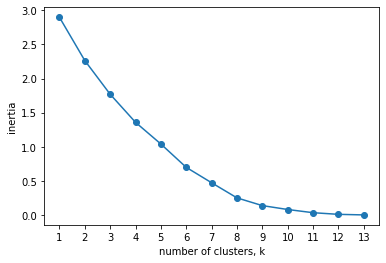

In [170]:
from sklearn.cluster import KMeans


ks = range(1,14)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(tendencies)
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()